# 1. 라이브러리 로드

In [1173]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder

In [1174]:
pd.set_option('display.max_columns', None)

In [1175]:
# 맷플롯립 한글 설정 
# matplotlib Korean font
plt.rc('font', family='Malgun Gothic')

# 2. 데이터 불러오기

In [1176]:
# 1. 상가 공실률 파일 불러오기 
vacancy = gpd.read_file('input/Sejong/102.상가_공실률.geojson')

# 2. brt 라인 불러오기
brt_line = gpd.read_file('input/Sejong/brt_line.geojson')

# 3. 거주인구, 유동인구, 카드매출, 대중교통 정보 가져오기
res_pop = pd.read_csv('output/대상구역_거주인구_2020_2023.csv')
float_pop = pd.read_csv('output/유동인구_총합.csv')
card = pd.read_csv('output/도로명별카드매출.csv')
trans = pd.read_csv('output/대상구역_도로명주소별_대중교통.csv')

In [1177]:
# 2. brt 라인 좌표계 설정
brt_line.set_crs('epsg:4326')
brt_line.to_crs('epsg:5179', inplace=True)

# 3. 데이터 전처리

In [1178]:
res_pop_20 = res_pop[res_pop['year']==2022].drop('Unnamed: 0', axis=1)
res_pop_20.drop('year', axis=1, inplace=True)
res_pop_20.describe()

,거주인구_총합
count,1743.000000
mean,2841.050488
std,2583.336766
min,0.000000
25%,898.000000
50%,2270.000000
75%,4017.500000
max,16667.000000


In [1179]:
float_pop_20 = float_pop[float_pop['년도']==2022].drop('Unnamed: 0', axis=1)
float_pop_20.drop('년도', axis=1, inplace=True)
float_pop_20.describe()

,유동인구_총합
count,1.743000e+03
mean,2.366931e+05
std,1.753711e+05
min,1.426000e+01
25%,1.265324e+05
50%,2.000464e+05
75%,2.897615e+05
max,1.533548e+06


In [1180]:
# 카드매출 데이터 확인
print(card.rd_addr.nunique())
card.head()

548


,Unnamed: 0,rd_addr,KBC_BZC_NM_1,CARD_SALES,EST_SALES
0,0,세종특별자치시 가름로 143,서비스,98321000.0,1066918.0
1,1,세종특별자치시 가름로 143,소매업,49880900.0,265223.0
2,2,세종특별자치시 가름로 143,음식,309914279.0,447205.0
3,3,세종특별자치시 가름로 170-14,소매업,30901760.0,300001.0
4,4,세종특별자치시 가름로 170-14,음식,25221600.0,283250.0


In [1181]:
# 카드 전처리
pivot_card = card.pivot_table(index='rd_addr', 
                             columns = 'KBC_BZC_NM_1',
                             values = 'CARD_SALES',
                             aggfunc = 'sum').reset_index()
pivot_card.fillna(0, inplace=True)
pivot_card

KBC_BZC_NM_1,rd_addr,기타,서비스,소매업,음식
0,세종특별자치시 가름로 143,0.0,98321000.0,49880900.0,309914279.0
1,세종특별자치시 가름로 170-14,0.0,0.0,30901760.0,25221600.0
2,세종특별자치시 가름로 180,0.0,0.0,149120661.0,71346720.0
3,세종특별자치시 가름로 194,0.0,0.0,595778306.0,38761670.0
4,세종특별자치시 가름로 232,0.0,2456000.0,59558870.0,354983224.0
...,...,...,...,...,...
543,세종특별자치시 호려울로 29,0.0,77020100.0,228000.0,184264465.0
544,세종특별자치시 호려울로 42,0.0,2092100.0,0.0,0.0
545,세종특별자치시 호려울로 45,0.0,44098500.0,88522430.0,92605498.0
546,세종특별자치시 호려울로 51,0.0,139772010.0,40865000.0,239580745.0


In [1182]:
trans.head()

,Unnamed: 0,rd_addr,type,대중교통_총합
0,0,세종특별자치시 가름로 143,byc,1
1,1,세종특별자치시 갈매로 294,bus,1
2,2,세종특별자치시 갈매로 408,byc,1
3,3,세종특별자치시 갈매로 479,byc,1
4,4,세종특별자치시 국세청로 45,byc,2


In [1183]:
trans.describe()

,Unnamed: 0,대중교통_총합
count,123.000000,123.000000
mean,61.000000,1.439024
std,35.651087,0.725940
min,0.000000,1.000000
25%,30.500000,1.000000
50%,61.000000,1.000000
75%,91.500000,2.000000
max,122.000000,5.000000


In [1184]:
# 대중교통 총합으로 합치기
trans = trans.groupby('rd_addr').sum('대중교통_총합').drop('Unnamed: 0', axis =1).reset_index()
trans

,rd_addr,대중교통_총합
0,세종특별자치시 가름로 143,1
1,세종특별자치시 갈매로 294,1
2,세종특별자치시 갈매로 408,1
3,세종특별자치시 갈매로 479,1
4,세종특별자치시 국세청로 45,2
...,...,...
99,세종특별자치시 한누리대로 511,1
100,세종특별자치시 한솔동로 26,2
101,세종특별자치시 해들로 48,1
102,세종특별자치시 해밀3로 32,5


In [1185]:
# brt_line 과의 거리 연산
vacancy['brt_distance'] = vacancy.distance(brt_line.unary_union)
vacancy.tail()

,rd_addr_left,date,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,rd_addr,arch_area,bc_rat,buld_nm,buld_type,height,tot_area,tot_sanga_area,use_apr_day,2020,2021,2022,2023,2024,index_right,EMD_CD,행정동,보증금,월세,보증금/전용,월세/전용,centroid,distance_to_center,vacancy_rat,geometry,brt_distance
89227,세종특별자치시 호려울로 9,2024-01,50,0,3451.39,0.0,세종특별자치시 호려울로 9,1251.13,69.681425,네이버타워,제1종근린생활시설,31.2,13820.8,8946.609999999999,2016-11-25T00:00:00,0.0,3295000.0,3475000.0,3261000.0,3176000.0,7.0,36110103,보람동,2108.759124,124.79927,34.734173,2.092847,POINT (981030.3625235744 1831072.678229407),158.479883,20.340624,"POLYGON ((981044.199 1831096.161, 981056.614 1...",111.948177
89228,세종특별자치시 호려울로 9,2024-02,50,0,3451.39,0.0,세종특별자치시 호려울로 9,1251.13,69.681425,네이버타워,제1종근린생활시설,31.2,13820.8,8946.609999999999,2016-11-25T00:00:00,0.0,3295000.0,3475000.0,3261000.0,3176000.0,7.0,36110103,보람동,2108.759124,124.79927,34.734173,2.092847,POINT (981030.3625235744 1831072.678229407),158.479883,20.340624,"POLYGON ((981044.199 1831096.161, 981056.614 1...",111.948177
89229,세종특별자치시 호려울로 9,2024-03,52,0,3560.83,0.0,세종특별자치시 호려울로 9,1251.13,69.681425,네이버타워,제1종근린생활시설,31.2,13820.8,8946.609999999999,2016-11-25T00:00:00,0.0,3295000.0,3475000.0,3261000.0,3176000.0,7.0,36110103,보람동,2108.759124,124.79927,34.734173,2.092847,POINT (981030.3625235744 1831072.678229407),158.479883,19.548774,"POLYGON ((981044.199 1831096.161, 981056.614 1...",111.948177
89230,세종특별자치시 호려울로 9,2024-04,52,0,3652.51,0.0,세종특별자치시 호려울로 9,1251.13,69.681425,네이버타워,제1종근린생활시설,31.2,13820.8,8946.609999999999,2016-11-25T00:00:00,0.0,3295000.0,3475000.0,3261000.0,3176000.0,7.0,36110103,보람동,2108.759124,124.79927,34.734173,2.092847,POINT (981030.3625235744 1831072.678229407),158.479883,18.885426,"POLYGON ((981044.199 1831096.161, 981056.614 1...",111.948177
89231,세종특별자치시 호려울로 9,2024-05,50,0,3431.76,0.0,세종특별자치시 호려울로 9,1251.13,69.681425,네이버타워,제1종근린생활시설,31.2,13820.8,8946.609999999999,2016-11-25T00:00:00,0.0,3295000.0,3475000.0,3261000.0,3176000.0,7.0,36110103,보람동,2108.759124,124.79927,34.734173,2.092847,POINT (981030.3625235744 1831072.678229407),158.479883,20.482657,"POLYGON ((981044.199 1831096.161, 981056.614 1...",111.948177


# 3. 연도별 데이터 추출 후 병합

In [1186]:
# 필요 없는 데이터 drop
vacancy.drop(['index_right', 'buld_type', 'EMD_CD','rd_addr_left',
               'geometry','centroid'], axis=1, inplace=True)


# 열 이름 변경 
vacancy.rename(columns={'행정동': 'emd',
                        '보증금': 'deposit',
                       '월세': 'rent',
                       '보증금/전용' : 'deposit_per_sqm',
                       '월세/전용' : 'rent_per_sqm'}, inplace=True)

In [1187]:
# 연도별 데이터만 추출

vacancy1605 = vacancy[vacancy['date']=='2016-05']
vacancy2005 = vacancy[vacancy['date']=='2020-05']
vacancy2105 = vacancy[vacancy['date']=='2021-05']
vacancy2205 = vacancy[vacancy['date']=='2022-05']
vacancy2305 = vacancy[vacancy['date']=='2023-05']
vacancy2405 = vacancy[vacancy['date']=='2024-05']
vacancy2405.head()

,date,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,rd_addr,arch_area,bc_rat,buld_nm,height,tot_area,tot_sanga_area,use_apr_day,2020,2021,2022,2023,2024,emd,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance
142,2024-05,15,3,3208.97,0.200000,세종특별자치시 가름로 143,4194.940,69.8994,KT&G세종타워B,50.8,48074.700,10666.529999999999,2020-05-28T00:00:00,3605000.0,3836000.0,4150000.0,3931000.0,3825000.0,어진동,2774.285714,174.478571,31.145627,1.877481,751.303347,8.856220,146.512662
285,2024-05,23,1,1141.84,0.043478,세종특별자치시 가름로 170-14,NaN,None,None,None,NaN,None,None,2640000.0,3056000.0,3336000.0,3128000.0,3011000.0,어진동,2774.285714,174.478571,31.145627,1.877481,757.243857,NaN,83.123649
428,2024-05,17,0,1765.69,0.000000,세종특별자치시 가름로 180,4693.400,69.89,세종파이낸스센터3,26.65,45606.300,11319.73,2018-02-21T00:00:00,3368000.0,3950000.0,4264000.0,3998000.0,3892000.0,어진동,2774.285714,174.478571,31.145627,1.877481,634.708287,13.502786,114.634385
571,2024-05,3,0,304.73,0.000000,세종특별자치시 가름로 194,5477.780,69.99,None,26.45,54271.070,14265.8,2018-08-01T00:00:00,3625000.0,3950000.0,4264000.0,3998000.0,3892000.0,어진동,2774.285714,174.478571,31.145627,1.877481,622.164240,17.838841,292.756815
714,2024-05,116,1,6733.24,0.008621,세종특별자치시 가름로 232,6243.478,68.6,세종비지니스센터,25.54,52650.275,17764.912,2016-12-06T00:00:00,3520000.0,3835000.0,4140000.0,3843000.0,3741000.0,어진동,2774.285714,174.478571,31.145627,1.877481,719.323362,10.830330,624.718856


In [1188]:
# 원핫인코딩
encoder = OneHotEncoder(sparse=False)

In [1189]:
def data_concat(df):
    # 거주인구 합산
    df = pd.merge(df, res_pop_20, on ='rd_addr', how='left')
    # 유동인구 합산 
    df = pd.merge(df, float_pop_20, on ='rd_addr', how='left')
    # 카드 매출 데이터 합산
    df = pd.merge(df, pivot_card, on = 'rd_addr', how = 'left')
    # 대중교통 데이터 합산
    df = pd.merge(df, trans, on ='rd_addr', how='left')
    # 안 쓰는 데이터 정리

    # 사용승인일 datetime 형식으로
    df['use_apr_day'] = pd.to_datetime(df['use_apr_day']).dt.year
    
    # buld_type 컬럼에 대해서 one-hot encoding
    # null 값 처리
#     df['buld_type'].dropna(inplace=True)
    encoded = encoder.fit_transform(df['emd'].values.reshape(-1, 1))
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names(['emd']))
    df = pd.concat([df, encoded_df], axis=1)
    
    # 안 쓰는 컬럼 정리
    df.drop(['rd_addr', 'date', 'emd'], axis =1, inplace=True)
    # 컬럼 명 수정
    df.rename(columns ={'거주인구_총합':'res_pop',
                                '유동인구_총합' :'floating_pop',
                                '대중교통_총합_BRT':'BRT',
                                '대중교통_총합_bus':'BUS',
                                '대중교통_총합_byc' :'BYC',
                                 'buld_type_업무시설' : 'buld_work', 
                                 'buld_type_제1종근린생활시설' : 'buld_type1',
                                 'buld_type_제2종근린생활시설': 'buld_type2',
                                  'buld_type_제2종근린생활시설, 제1종근린생활시설': 'buld_type1, 2', 
                                 'buld_type_제2종근린생활시설, 판매시설' : 'buld_type2, sell',
                                 'buld_type_판매시설, 제2종근린생활시설' : 'buld_sell, type2',
                                 'buld_type_판매시설' : 'buld_sell',
                                 '기타' : 'card_etc',
                                 '서비스' : 'card_service',
                                 '소매업' : 'card_retail', 
                                 '음식' : 'card_f&b',
                                '대중교통_총합':'transport'}, inplace=True)
    
    # 공실률이 null 인 행들 제외
    df = df[~df['vacancy_rat'].isna()]
    
    # 결측치 채우기
    df['res_pop'].fillna(0, inplace=True)
    df['frnch_ratio'].fillna(0, inplace=True)
    df['floating_pop'].fillna(0, inplace=True)
    df['card_etc'].fillna(0, inplace=True)
    df['card_service'].fillna(0, inplace=True)
    df['card_retail'].fillna(0, inplace=True)
    df['card_f&b'].fillna(0, inplace=True)
    df['transport'].fillna(0, inplace=True)
    df['bc_rat'] = df['bc_rat'].astype(float)
#     df['buld_work'].fillna(0, inplace=True)
#     df['buld_type1'].fillna(0, inplace=True)
#     df['buld_type2'].fillna(0, inplace=True)
#     df['buld_type1, 2'].fillna(0, inplace=True)
#     df['buld_sell'].fillna(0, inplace=True)
    print(df.shape)
    return df

# 일괄 적용
vacancy1605 = data_concat(vacancy1605) 
vacancy2005 = data_concat(vacancy2005) 
vacancy2105 = data_concat(vacancy2105) 
vacancy2205 = data_concat(vacancy2205)
vacancy2305 = data_concat(vacancy2305)
vacancy2405 = data_concat(vacancy2405)
vacancy2405.head()

(162, 46)
(360, 46)
(368, 46)
(378, 46)
(384, 46)
(388, 46)


,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,bc_rat,buld_nm,height,tot_area,tot_sanga_area,use_apr_day,2020,2021,2022,2023,2024,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance,res_pop,floating_pop,card_etc,card_service,card_retail,card_f&b,transport,emd_고운동,emd_나성동,emd_다정동,emd_대평동,emd_도담동,emd_반곡동,emd_보람동,emd_새롬동,emd_소담동,emd_아름동,emd_어진동,emd_종촌동,emd_집현동,emd_한솔동,emd_해밀동,emd_None
0,15,3,3208.97,0.200000,4194.940,69.8994,KT&G세종타워B,50.8,48074.700,10666.529999999999,2020.0,3605000.0,3836000.0,4150000.0,3931000.0,3825000.0,2774.285714,174.478571,31.145627,1.877481,751.303347,8.856220,146.512662,2115.0,672919.02,0.0,98321000.0,49880900.0,309914279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,17,0,1765.69,0.000000,4693.400,69.8900,세종파이낸스센터3,26.65,45606.300,11319.73,2018.0,3368000.0,3950000.0,4264000.0,3998000.0,3892000.0,2774.285714,174.478571,31.145627,1.877481,634.708287,13.502786,114.634385,363.0,538850.92,0.0,0.0,149120661.0,71346720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,304.73,0.000000,5477.780,69.9900,None,26.45,54271.070,14265.8,2018.0,3625000.0,3950000.0,4264000.0,3998000.0,3892000.0,2774.285714,174.478571,31.145627,1.877481,622.164240,17.838841,292.756815,894.0,317369.26,0.0,0.0,595778306.0,38761670.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,116,1,6733.24,0.008621,6243.478,68.6000,세종비지니스센터,25.54,52650.275,17764.912,2016.0,3520000.0,3835000.0,4140000.0,3843000.0,3741000.0,2774.285714,174.478571,31.145627,1.877481,719.323362,10.830330,624.718856,1652.0,240231.52,0.0,2456000.0,59558870.0,354983224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,26,4,563.24,0.153846,4028.440,77.7400,세종시 2차 푸르지오시티,66.9,48373.240,949.29,2014.0,3555000.0,3835000.0,4140000.0,3843000.0,3741000.0,2774.285714,174.478571,31.145627,1.877481,783.463267,0.209337,825.792674,1652.0,206743.24,3106100.0,2311000.0,66287600.0,3471200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1190]:
# 전체적인 구조 파악 : Null 값 확인

vacancy1605.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)
vacancy2005.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)
vacancy2105.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)
vacancy2205.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)
vacancy2305.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)
vacancy2405.fillna({'deposit': 0, 'rent': 0, 'deposit_per_sqm': 0, 'rent_per_sqm': 0,
                   '2020': 0, '2021': 0, '2022': 0, '2023':0, '2024': 0}, inplace=True)

# vacancy1605['buld_type_NaT'].fillna(0, inplace=True)
# vacancy2005['buld_type_NaT'].fillna(0, inplace=True)
# vacancy2105['buld_type_NaT'].fillna(0, inplace=True)
# vacancy2205['buld_type_NaT'].fillna(0, inplace=True)
# vacancy2305['buld_type_NaT'].fillna(0, inplace=True)
# vacancy2105['buld_type2, sell'].fillna(0, inplace=True)
# vacancy2205['buld_type2, sell'].fillna(0, inplace=True)
# vacancy2305['buld_type2, sell'].fillna(0, inplace=True)
# vacancy2205['buld_sell, type2'].fillna(0, inplace=True)
# vacancy2305['buld_sell, type2'].fillna(0, inplace=True)
# vacancy2405['buld_sell, type2'].fillna(0, inplace=True)
# vacancy2305['buld_type2, sell'].fillna(0, inplace=True)
# vacancy2405['buld_type2, sell'].fillna(0, inplace=True)

In [1191]:
vacancy2405.isnull().sum()

Tot_Rooms              0
Tot_frnchs             0
sanga_area             0
frnch_ratio            0
arch_area              0
bc_rat                 0
buld_nm               57
height                 0
tot_area               0
tot_sanga_area         0
use_apr_day            0
2020                   0
2021                   0
2022                   0
2023                   0
2024                   0
deposit                0
rent                   0
deposit_per_sqm        0
rent_per_sqm           0
distance_to_center     0
vacancy_rat            0
brt_distance           0
res_pop                0
floating_pop           0
card_etc               0
card_service           0
card_retail            0
card_f&b               0
transport              0
emd_고운동                0
emd_나성동                0
emd_다정동                0
emd_대평동                0
emd_도담동                0
emd_반곡동                0
emd_보람동                0
emd_새롬동                0
emd_소담동                0
emd_아름동                0


In [1192]:
vacancy.describe()

,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,tot_area,2020,2021,2022,2023,2024,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance
count,89232.000000,89232.000000,89232.000000,58751.000000,34383.000000,34383.000000,8.394100e+04,8.394100e+04,8.394100e+04,8.394100e+04,8.394100e+04,85514.000000,85514.000000,85514.000000,85514.000000,89232.000000,34383.000000,89232.000000
mean,6.630435,0.478046,662.989919,0.071055,931.425749,7219.467161,1.689231e+06,2.688211e+06,2.935158e+06,2.847618e+06,2.798198e+06,2481.374721,147.816412,36.188939,2.123581,1594.940618,25.466510,744.710896
std,13.684754,1.192056,3286.513869,0.159826,1258.588204,11128.531001,1.581802e+06,1.402573e+06,1.478627e+06,1.290921e+06,1.216386e+06,391.963181,27.064468,9.362653,0.578838,1013.172888,21.225554,759.242532
min,0.000000,0.000000,0.000000,0.000000,0.000000,98.280000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.470000e+04,1838.888889,108.444444,25.572495,1.487372,50.304756,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,198.040000,490.731000,0.000000e+00,1.545000e+06,1.713000e+06,1.642000e+06,1.672000e+06,2108.759124,116.970149,26.695873,1.511952,759.169102,8.378811,90.571825
50%,2.000000,0.000000,105.680000,0.000000,646.278200,2784.350000,1.420000e+06,2.540000e+06,2.764000e+06,2.646000e+06,2.662000e+06,2433.346667,146.020262,34.734173,2.050197,1390.490561,23.696384,535.757467
75%,8.000000,0.000000,583.700000,0.083333,1178.300000,10677.530000,3.278000e+06,3.835000e+06,4.156000e+06,3.931000e+06,3.782000e+06,2900.000000,171.294872,45.092323,2.667085,2302.985816,37.766023,1188.484953
max,740.000000,12.000000,104067.820000,1.000000,15578.480000,134569.270000,5.450000e+06,5.775000e+06,6.195000e+06,5.813000e+06,5.596000e+06,3651.219512,199.243902,72.579558,3.999957,6928.490351,95.186888,2731.147169


In [1193]:
# 공시지가 전처리 

vacancy1605.drop(['2021', '2022', '2023', '2024'], axis=1, inplace=True) # 2020년도의 공시지가만 남기고 드랍
vacancy1605.rename(columns={'2020':'land_price'}, inplace=True)

vacancy2005.drop(['2021', '2022', '2023', '2024'], axis=1, inplace=True) # 2020년도의 공시지가만 남기고 드랍
vacancy2005.rename(columns={'2020':'land_price'}, inplace=True)

vacancy2105.drop(['2020', '2022', '2023', '2024'], axis=1, inplace=True) # 2021년도의 공시지가만 남기고 드랍
vacancy2105.rename(columns={'2021':'land_price'}, inplace=True)

vacancy2205.drop(['2020', '2021', '2023', '2024'], axis=1, inplace=True) # 2022년도의 공시지가만 남기고 드랍
vacancy2205.rename(columns={'2022':'land_price'}, inplace=True)

vacancy2305.drop(['2020', '2021', '2022', '2024'], axis=1, inplace=True) # 2023년도의 공시지가만 남기고 드랍
vacancy2305.rename(columns={'2023':'land_price'}, inplace=True)

vacancy2405.drop(['2020', '2021', '2022', '2023'], axis=1, inplace=True) # 2024년도의 공시지가만 남기고 드랍
vacancy2405.rename(columns={'2024':'land_price'}, inplace=True)
vacancy2405.head()

,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,bc_rat,buld_nm,height,tot_area,tot_sanga_area,use_apr_day,land_price,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance,res_pop,floating_pop,card_etc,card_service,card_retail,card_f&b,transport,emd_고운동,emd_나성동,emd_다정동,emd_대평동,emd_도담동,emd_반곡동,emd_보람동,emd_새롬동,emd_소담동,emd_아름동,emd_어진동,emd_종촌동,emd_집현동,emd_한솔동,emd_해밀동,emd_None
0,15,3,3208.97,0.200000,4194.940,69.8994,KT&G세종타워B,50.8,48074.700,10666.529999999999,2020.0,3825000.0,2774.285714,174.478571,31.145627,1.877481,751.303347,8.856220,146.512662,2115.0,672919.02,0.0,98321000.0,49880900.0,309914279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,17,0,1765.69,0.000000,4693.400,69.8900,세종파이낸스센터3,26.65,45606.300,11319.73,2018.0,3892000.0,2774.285714,174.478571,31.145627,1.877481,634.708287,13.502786,114.634385,363.0,538850.92,0.0,0.0,149120661.0,71346720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,304.73,0.000000,5477.780,69.9900,None,26.45,54271.070,14265.8,2018.0,3892000.0,2774.285714,174.478571,31.145627,1.877481,622.164240,17.838841,292.756815,894.0,317369.26,0.0,0.0,595778306.0,38761670.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,116,1,6733.24,0.008621,6243.478,68.6000,세종비지니스센터,25.54,52650.275,17764.912,2016.0,3741000.0,2774.285714,174.478571,31.145627,1.877481,719.323362,10.830330,624.718856,1652.0,240231.52,0.0,2456000.0,59558870.0,354983224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,26,4,563.24,0.153846,4028.440,77.7400,세종시 2차 푸르지오시티,66.9,48373.240,949.29,2014.0,3741000.0,2774.285714,174.478571,31.145627,1.877481,783.463267,0.209337,825.792674,1652.0,206743.24,3106100.0,2311000.0,66287600.0,3471200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1286]:
# 세로 방향으로 합치기
vacancy05 = pd.concat([vacancy2005, vacancy2105, vacancy2205, vacancy2305, vacancy2405], axis=0)
vacancy05['height'] = vacancy05['height'].astype(float)
print(vacancy05.shape)
vacancy05.head()

(1878, 42)


,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,bc_rat,buld_nm,height,tot_area,tot_sanga_area,use_apr_day,land_price,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance,res_pop,floating_pop,card_etc,card_service,card_retail,card_f&b,transport,emd_고운동,emd_나성동,emd_다정동,emd_대평동,emd_도담동,emd_반곡동,emd_보람동,emd_새롬동,emd_소담동,emd_아름동,emd_어진동,emd_종촌동,emd_집현동,emd_한솔동,emd_해밀동,emd_None
2,4,0,200.160,0.000000,4693.4000,69.89,세종파이낸스센터3,26.65,45606.300,11319.73,2018.0,3368000.0,2774.285714,174.478571,31.145627,1.877481,634.708287,16.935491,114.634385,363.0,538850.92,0.0,0.0,149120661.0,71346720.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,15,0,1336.810,0.000000,5477.7800,69.99,None,26.45,54271.070,14265.8,2018.0,3625000.0,2774.285714,174.478571,31.145627,1.877481,622.164240,15.937128,292.756815,894.0,317369.26,0.0,0.0,595778306.0,38761670.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,63,1,3951.150,0.015873,6243.4780,68.60,세종비지니스센터,25.54,52650.275,17764.912,2016.0,3520000.0,2774.285714,174.478571,31.145627,1.877481,719.323362,16.114424,624.718856,1652.0,240231.52,0.0,2456000.0,59558870.0,354983224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,19,3,465.055,0.157895,4028.4400,77.74,세종시 2차 푸르지오시티,66.90,48373.240,949.29,2014.0,3555000.0,2774.285714,174.478571,31.145627,1.877481,783.463267,0.412311,825.792674,1652.0,206743.24,3106100.0,2311000.0,66287600.0,3471200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,9,0,757.450,0.000000,10.7002,0.11,가온마을11단지,3.55,2103.728,72.9059,2019.0,0.0,3163.865546,194.537815,45.092323,2.728549,759.810851,0.000000,93.375853,8198.0,250144.87,6172182.0,14277000.0,124105610.0,103179977.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1287]:
# 주거단지와 비주거단지 분리
living_vac = vacancy05[vacancy05['buld_nm'].str.contains('단지', na=False)]
non_living_vac = vacancy05[~vacancy05['buld_nm'].str.contains('단지', na=False)]

living_vac.drop('buld_nm', axis=1, inplace = True)
non_living_vac.drop('buld_nm', axis=1, inplace = True)
vacancy05.drop('buld_nm', axis=1, inplace=True)

In [1288]:
living_vac.isnull().sum()

Tot_Rooms             0
Tot_frnchs            0
sanga_area            0
frnch_ratio           0
arch_area             0
bc_rat                0
height                0
tot_area              0
tot_sanga_area        0
use_apr_day           0
land_price            0
deposit               0
rent                  0
deposit_per_sqm       0
rent_per_sqm          0
distance_to_center    0
vacancy_rat           0
brt_distance          0
res_pop               0
floating_pop          0
card_etc              0
card_service          0
card_retail           0
card_f&b              0
transport             0
emd_고운동               0
emd_나성동               0
emd_다정동               0
emd_대평동               0
emd_도담동               0
emd_반곡동               0
emd_보람동               0
emd_새롬동               0
emd_소담동               0
emd_아름동               0
emd_어진동               0
emd_종촌동               0
emd_집현동               0
emd_한솔동               0
emd_해밀동               0
emd_None              0
dtype: int64

In [1289]:
# 각각의 결측치 제거
living_vac.dropna(axis=1, inplace=True)
non_living_vac.dropna(axis=1, inplace=True)
vacancy05.dropna(axis=1, inplace=True)

print(living_vac.shape)
print(non_living_vac.shape)
print(vacancy05.shape)

(520, 41)
(1358, 41)
(1878, 41)


# 4. 머신러닝 수행

In [1290]:
# 종속변수 공실률로 설정하여 데이터 전처리 수행 

In [1291]:
non_living_vac.dtypes

Tot_Rooms               int64
Tot_frnchs              int64
sanga_area            float64
frnch_ratio           float64
arch_area             float64
bc_rat                float64
height                float64
tot_area              float64
tot_sanga_area         object
use_apr_day           float64
land_price            float64
deposit               float64
rent                  float64
deposit_per_sqm       float64
rent_per_sqm          float64
distance_to_center    float64
vacancy_rat           float64
brt_distance          float64
res_pop               float64
floating_pop          float64
card_etc              float64
card_service          float64
card_retail           float64
card_f&b              float64
transport             float64
emd_고운동               float64
emd_나성동               float64
emd_다정동               float64
emd_대평동               float64
emd_도담동               float64
emd_반곡동               float64
emd_보람동               float64
emd_새롬동               float64
emd_소담동   

In [1292]:
living_vac

,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,bc_rat,height,tot_area,tot_sanga_area,use_apr_day,land_price,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance,res_pop,floating_pop,card_etc,card_service,card_retail,card_f&b,transport,emd_고운동,emd_나성동,emd_다정동,emd_대평동,emd_도담동,emd_반곡동,emd_보람동,emd_새롬동,emd_소담동,emd_아름동,emd_어진동,emd_종촌동,emd_집현동,emd_한솔동,emd_해밀동,emd_None
7,9,0,757.450,0.000000,10.7002,0.11,3.55,2103.7280,72.9059,2019.0,0.0,3163.865546,194.537815,45.092323,2.728549,759.810851,0.000000,93.375853,8198.0,250144.87,6172182.0,14277000.0,124105610.0,103179977.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2,1,149.720,0.500000,0.0000,0.00,0.00,244.2169,218.7169,2018.0,0.0,3163.865546,194.537815,45.092323,2.728549,851.857466,0.484668,211.077575,12950.0,222390.81,0.0,7187560.0,0.0,12423764.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,3,2,92.440,0.666667,0.0000,0.00,0.00,247.6130,247.613,2013.0,1536000.0,2774.285714,174.478571,31.145627,1.877481,615.207226,11.433642,282.624435,6079.0,434728.99,0.0,3834000.0,40612880.0,12576800.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21,6,0,220.430,0.000000,560.6600,0.00,5.20,421.4120,421.412,2013.0,1490000.0,2774.285714,174.478571,31.145627,1.877481,642.234751,6.192382,548.212585,3761.0,321220.36,620000.0,10324000.0,17673000.0,3172800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,15,4,584.225,0.266667,1859.1134,0.00,3.80,1795.4874,1795.4874,2016.0,0.0,2433.346667,116.866667,38.779304,2.050197,1627.557382,13.111519,62.758114,4118.0,150222.88,0.0,33614200.0,29909440.0,51533500.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,24,2,1244.545,0.083333,2316.5364,0.00,4.87,4217.2602,3159.0218,2016.0,1672000.0,0.000000,0.000000,0.000000,0.000000,946.181948,8.023446,16.949010,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
487,62,5,1629.300,0.080645,162.8300,0.00,0.00,1094.1800,805.94,2019.0,1821000.0,2566.666667,167.500000,46.899107,2.896076,3285.311193,0.000000,72.410581,3637.0,96509.59,0.0,25372150.0,46735340.0,15693790.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,6,1,90.785,0.166667,0.0000,0.00,0.00,561.0816,561.0816,2015.0,1557000.0,2436.111111,141.583333,31.380263,1.844000,2057.329007,18.836875,1337.332783,9557.0,1052146.34,31287750.0,17572000.0,33891730.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
517,0,0,0.000,0.000000,0.0000,0.00,9.25,7130.5119,47.6471,2021.0,2173000.0,2327.294398,146.020262,35.946520,2.228512,473.302189,0.163713,575.174009,677.0,199500.37,1150000.0,32725500.0,102676320.0,143317297.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1293]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 정규화
scaler = MinMaxScaler()

# 전처리 및 정규화 적용
living_vac_processed = scaler.fit_transform(living_vac)
non_living_vac_processed = scaler.fit_transform(non_living_vac)

# 스케일링된 데이터를 데이터프레임으로 변환
living_vac_processed = pd.DataFrame(living_vac_processed, columns=living_vac.columns)
non_living_vac_processed = pd.DataFrame(non_living_vac_processed, columns=non_living_vac.columns)
non_living_vac_processed

,Tot_Rooms,Tot_frnchs,sanga_area,frnch_ratio,arch_area,bc_rat,height,tot_area,tot_sanga_area,use_apr_day,land_price,deposit,rent,deposit_per_sqm,rent_per_sqm,distance_to_center,vacancy_rat,brt_distance,res_pop,floating_pop,card_etc,card_service,card_retail,card_f&b,transport,emd_고운동,emd_나성동,emd_다정동,emd_대평동,emd_도담동,emd_반곡동,emd_보람동,emd_새롬동,emd_소담동,emd_아름동,emd_어진동,emd_종촌동,emd_집현동,emd_한솔동,emd_해밀동,emd_None
0,0.005405,0.000000,0.006140,0.000000,0.296878,0.884405,0.296078,0.338423,0.390719,0.454545,0.543664,0.705972,0.767006,0.194447,0.214069,0.174191,0.188172,0.044423,0.044161,0.800766,0.00000,0.000000,0.005216,0.100498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.020270,0.000000,0.041006,0.000000,0.347545,0.885671,0.293464,0.402859,0.492408,0.454545,0.585149,0.705972,0.767006,0.194447,0.214069,0.170452,0.177079,0.113449,0.108759,0.471631,0.00000,0.000000,0.020838,0.054599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.085135,0.090909,0.121198,0.015873,0.397005,0.868081,0.281569,0.390805,0.613186,0.272727,0.568200,0.705972,0.767006,0.194447,0.214069,0.199411,0.179049,0.242091,0.200973,0.356999,0.00000,0.002489,0.002083,0.500022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.025676,0.272727,0.014265,0.157895,0.253925,0.983741,0.822222,0.358999,0.032766,0.090909,0.573850,0.705972,0.767006,0.194447,0.214069,0.218529,0.004581,0.320011,0.200973,0.307233,0.05729,0.002342,0.002318,0.004889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.071622,0.181818,0.066719,0.037736,0.238850,0.874029,0.313464,0.257137,0.348953,0.272727,0.568200,0.705972,0.767006,0.194447,0.214069,0.221055,0.157065,0.166322,0.083090,0.317263,0.28773,0.180603,0.006215,0.013166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,0.017568,0.181818,0.077204,0.153846,0.133703,0.914902,0.845098,0.176829,0.513629,0.272727,0.622599,0.705972,0.767006,0.194447,0.214069,0.198056,0.367608,0.009264,0.516423,0.546931,0.00000,0.065288,0.000682,0.048036,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1354,0.039189,0.000000,0.086531,0.000000,0.081726,0.884201,0.428758,0.100513,0.241547,0.363636,0.512672,0.203679,0.189966,0.319652,0.332248,0.022757,0.169560,0.043565,0.455718,0.349449,0.00000,0.019213,0.000533,0.439313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1355,0.039189,0.000000,0.081983,0.000000,0.074681,0.878968,0.433987,0.098819,0.237604,0.363636,0.512672,0.203679,0.189966,0.319652,0.332248,0.032247,0.178115,0.045141,0.364477,0.338621,0.00000,0.078059,0.000008,0.259551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1356,0.058108,0.181818,0.096434,0.046512,0.081450,0.881120,0.403922,0.109191,0.336162,0.272727,0.512672,0.203679,0.189966,0.319652,0.332248,0.011292,0.276141,0.028661,0.368978,0.345445,0.00000,0.141658,0.001429,0.337469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1) 머신러닝 시행 - Decision Tree, Random Forest

In [1294]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [1295]:
# 특성(X)과 타겟(y) 분리
X = vacancy05.drop(['vacancy_rat', 'sanga_area', 'tot_sanga_area', 'Tot_Rooms', 'tot_area'], axis=1)
y = vacancy05['vacancy_rat']

# 트레이닝 셋과 테스트 셋으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [1296]:
# 데이터 타입 확인 및 변환
X_train = X_train.astype(float)
y_train = y_train.astype(float)

In [1297]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Gradient Boosting Regressor 모델 생성 및 학습
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# 테스트 셋에 대한 예측
predictions = gbr.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# 모델 성능 출력
r2_score = gbr.score(X_test, y_test)
print(f"R^2 Score: {r2_score}")


Mean Squared Error: 121.21138295207537
R^2 Score: 0.7440064008076798


In [1298]:
# RandomForest 모델 생성 및 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# 테스트 셋에 대한 예측
y_pred = rf.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# 모델 성능 출력
r2_score = rf.score(X_test, y_test)
print(f"R^2 Score: {r2_score}")


Mean Squared Error: 121.21138295207537
R^2 Score: 0.8692778767036574


In [1301]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [1308]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20;

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=42, verbose=2)

In [1309]:
# 최적의 파라미터 출력
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}  



In [1330]:
from sklearn.metrics import mean_squared_error, r2_score
# 최적의 파라미터를 사용하여 모델을 재학습
best_rf = rf_random.best_estimator_

# 테스트 셋에 대한 예측
y_pred = best_rf.predict(X_test)

# 모델 성능 평가 (R^2 스코어와 MSE 출력)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
# RMSE 계산
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 54.5583586123173
Root Mean Squared Error (RMSE): 7.38636301655404
R^2 Score: 0.8847749258605972


In [1312]:
# 특성 중요도 출력
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))


Top 10 Important Features:
               feature  importance
3               bc_rat    0.155505
4               height    0.123581
13             res_pop    0.085974
2            arch_area    0.081765
11  distance_to_center    0.067115
12        brt_distance    0.066561
14        floating_pop    0.065522
18            card_f&b    0.054278
16        card_service    0.053233
6           land_price    0.052782


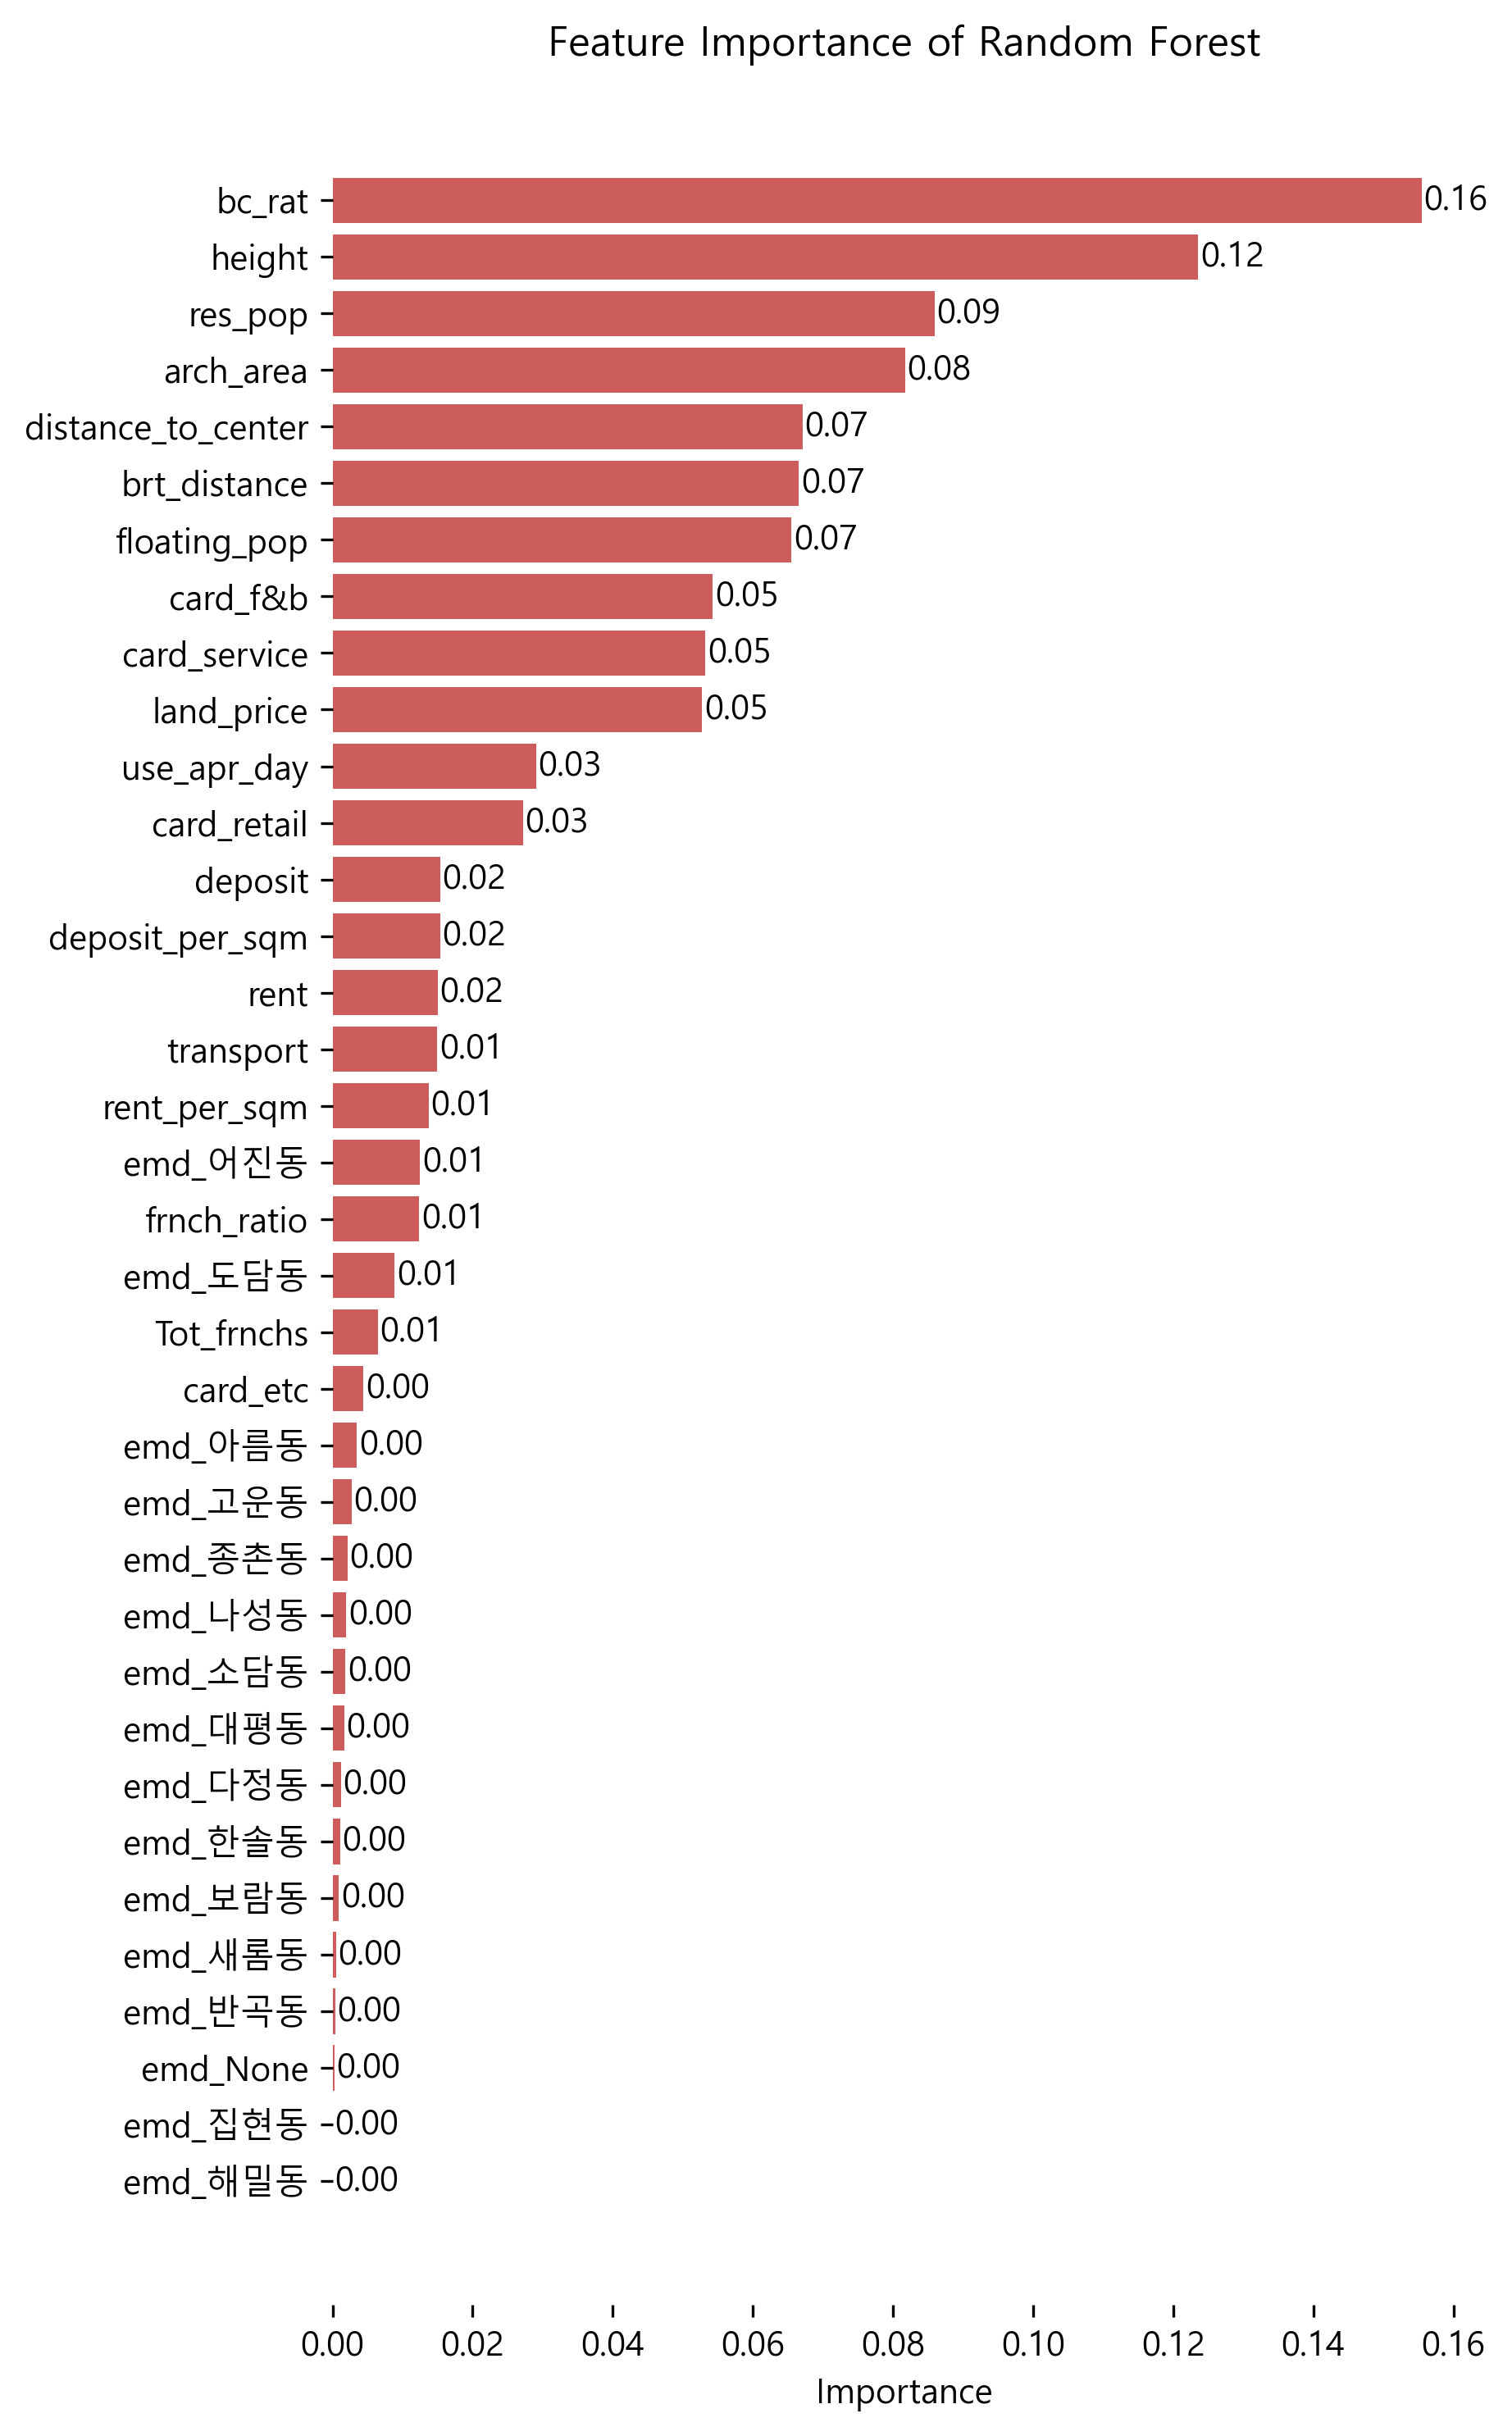

In [1313]:
# Feature Importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(6, 12), dpi=300)
bars = plt.barh(feature_importance['feature'], feature_importance['importance'], color='indianred')
plt.xlabel('Importance')
plt.title('Feature Importance of Random Forest')
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Removing edges and grid
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.grid(False)

# Adding value annotations
for bar in bars:
    plt.text(bar.get_width()+0.0003, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.show()

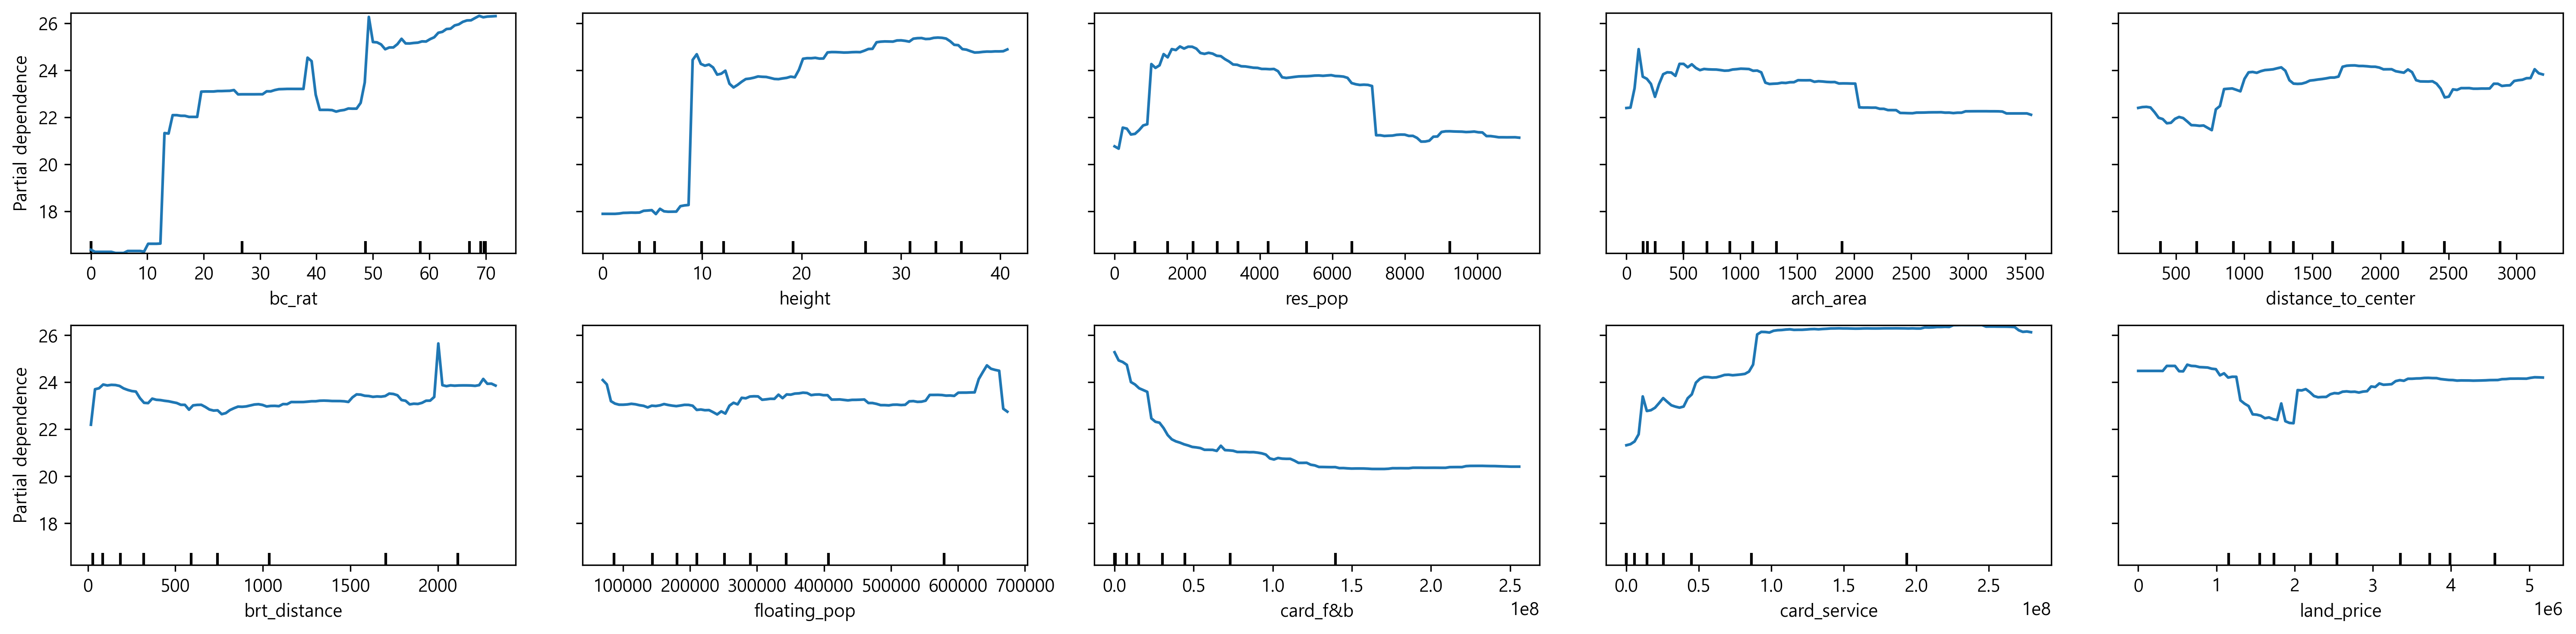

In [1329]:
from sklearn.inspection import plot_partial_dependence
# Partial Dependence Plot 생성

top_features = feature_importance['feature'].head(10).to_list()  # 상위 5개 특성 선택
fig, ax = plt.subplots(figsize=(20, 5), dpi=300)
plot_partial_dependence(best_rf, X_train, features=top_features, n_cols=5, ax=ax)
plt.tight_layout()

        
# 플롯 간의 간격 조절
plt.subplots_adjust(hspace=0.3, wspace=0.15)
plt.show()


# # 개별 특성에 대한 PDP
# for feature in top_features:
#     fig, ax = plt.subplots(figsize=(8, 6))
#     plot_partial_dependence(best_rf, X_train, features=[feature], ax=ax)
#     plt.title(f'Partial Dependence Plot for {feature}')
#     plt.tight_layout()
#     plt.show()